In [60]:
#pip install kagglehub

In [94]:
import csv
import pandas as pd
import hvplot.pandas
#import matplotlib as plt
import matplotlib.pyplot as plt
import os
from pprint import pprint
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/most-streamed-spotify-songs-2024")
if not os.path.exists(os.path.join("data", "spotify.csv")):
    file_name = os.listdir(path)[0]
    os.rename(os.path.join(path, file_name), os.path.join("data", "spotify.csv"))
spotify_df = pd.read_csv("data/spotify.csv", encoding='ISO-8859-1')

In [95]:
clean_df = spotify_df.drop(columns=['TIDAL Popularity'])
clean_df = clean_df.dropna()
for i in clean_df.columns:
    clean_df.rename(columns={i: (i.lower()).replace(" ", "_")}, inplace=True)
clean_df.head()

,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,airplay_spins,siriusxm_spins,deezer_playlist_count,deezer_playlist_reach,amazon_playlist_count,pandora_streams,pandora_track_stations,soundcloud_streams,shazam_counts,explicit_track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"40,975",684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,"40,778",3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,"74,333",536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",0
5,Lovin On Me,Lovin On Me,Jack Harlow,11/10/2023,USAT22311371,6,410.1,"670,665,438","105,892","175,421,034",...,"522,042","4,654",86.0,"17,167,254",152.0,"138,529,362","50,982","9,438,601","4,517,131",1
9,BAND4BAND (feat. Lil Baby),BAND4BAND (feat. Lil Baby),Central Cee,5/23/2024,USSM12404354,10,330.6,"90,676,573","10,400","184,199,419",...,"3,823",117,78.0,"10,800,098",92.0,"1,005,626",842,"3,679,709","666,302",1


In [96]:
for col in clean_df.columns:
    print(f"{col}")

track
album_name
artist
release_date
isrc
all_time_rank
track_score
spotify_streams
spotify_playlist_count
spotify_playlist_reach
spotify_popularity
youtube_views
youtube_likes
tiktok_posts
tiktok_likes
tiktok_views
youtube_playlist_reach
apple_music_playlist_count
airplay_spins
siriusxm_spins
deezer_playlist_count
deezer_playlist_reach
amazon_playlist_count
pandora_streams
pandora_track_stations
soundcloud_streams
shazam_counts
explicit_track


In [97]:
#Find duplicated lines
clean_df.duplicated().sum()

1

In [98]:
clean_df.shape

(565, 28)

In [99]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 4590
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   track                       565 non-null    object 
 1   album_name                  565 non-null    object 
 2   artist                      565 non-null    object 
 3   release_date                565 non-null    object 
 4   isrc                        565 non-null    object 
 5   all_time_rank               565 non-null    object 
 6   track_score                 565 non-null    float64
 7   spotify_streams             565 non-null    object 
 8   spotify_playlist_count      565 non-null    object 
 9   spotify_playlist_reach      565 non-null    object 
 10  spotify_popularity          565 non-null    float64
 11  youtube_views               565 non-null    object 
 12  youtube_likes               565 non-null    object 
 13  tiktok_posts                565 non-nul

In [100]:
clean_df.describe()

,track_score,spotify_popularity,apple_music_playlist_count,deezer_playlist_count,amazon_playlist_count,explicit_track
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,61.544425,69.722124,89.886726,42.557522,35.398230,0.405310
std,65.000014,11.175532,85.325438,59.133480,32.222118,0.491387
min,19.500000,6.000000,3.000000,1.000000,1.000000,0.000000
25%,28.100000,65.000000,32.000000,9.000000,13.000000,0.000000
50%,40.700000,71.000000,63.000000,26.000000,27.000000,0.000000
75%,69.700000,76.000000,122.000000,54.000000,45.000000,1.000000
max,725.400000,95.000000,859.000000,584.000000,188.000000,1.000000


In [101]:
clean_df[['spotify_streams','track']].value_counts().nlargest(20)

spotify_streams  track                         
227,893,586      Tennessee Orange                  2
1,010,494,713    Old Town Road                     1
516,523,975      What Ifs (feat. Lauren Alaina)    1
507,652,985      Soy Peor                          1
508,151,972      Caramelo                          1
508,914,869      Limbo                             1
510,302,007      Like That (feat. Gucci Mane)      1
512,194,074      Hell N Back                       1
513,353,284      Say Yes To Heaven                 1
518,988,585      Fast Car                          1
505,295,731      What A Man Gotta Do               1
52,106,559       ICU                               1
53,825,007       Good Good                         1
532,605,345      I KNOW ?                          1
536,110,386      Bejeweled                         1
537,523,729      The Weekend                       1
538,918,222      Boyfriend                         1
506,083,686      You Know You Like It              

In [102]:
import seaborn as sns
import numpy as np

In [103]:

    # Convert 'release date' to datetime format
clean_df['release_date'] = pd.to_datetime(clean_df['release_date'], format='%m/%d/%Y')

    # Create a new column 'Year' by extracting the year from 'release date'
clean_df['year_released'] = clean_df['release_date'].dt.year
  
    
    

clean_df.describe()

,release_date,track_score,spotify_popularity,apple_music_playlist_count,deezer_playlist_count,amazon_playlist_count,explicit_track,year_released
count,565,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2019-11-26 21:21:58.938053120,61.544425,69.722124,89.886726,42.557522,35.398230,0.405310,2019.456637
min,1991-09-24 00:00:00,19.500000,6.000000,3.000000,1.000000,1.000000,0.000000,1991.000000
25%,2018-05-04 00:00:00,28.100000,65.000000,32.000000,9.000000,13.000000,0.000000,2018.000000
50%,2021-02-05 00:00:00,40.700000,71.000000,63.000000,26.000000,27.000000,0.000000,2021.000000
75%,2022-12-05 00:00:00,69.700000,76.000000,122.000000,54.000000,45.000000,1.000000,2022.000000
max,2024-05-23 00:00:00,725.400000,95.000000,859.000000,584.000000,188.000000,1.000000,2024.000000
std,NaN,65.000014,11.175532,85.325438,59.133480,32.222118,0.491387,4.236825


In [104]:
print(clean_df['tiktok_views'].dtypes)
print(clean_df['spotify_streams'].dtypes)
print(clean_df['pandora_streams'].dtypes)
print(clean_df['deezer_playlist_count'].dtypes)

object
object
object
float64


In [106]:
# Convert relevant columns to numeric by removing commas if present
columns_to_convert = ['tiktok_views','spotify_streams','tiktok_posts','tiktok_likes','youtube_views','pandora_streams']
for column in columns_to_convert:
    clean_df[column] = clean_df[column].str.replace(',', '').astype(float)
    print(clean_df[column].dtypes)

AttributeError: Can only use .str accessor with string values!

In [107]:
clean_df['spotify_streams'] = clean_df['spotify_streams'].str.replace(',', '').astype(float)
clean_df['tiktok_views'] = clean_df['tiktok_views'].str.replace(',', '').astype(float)
clean_df['pandora_streams'] = clean_df['pandora_streams'].str.replace(',', '').astype(float)

AttributeError: Can only use .str accessor with string values!

In [108]:
print(clean_df['tiktok_views'].dtypes)
print(clean_df['spotify_streams'].dtypes)
print(clean_df['pandora_streams'].dtypes)
print(clean_df['deezer_playlist_count'].dtypes)

float64
float64
float64
float64


Correlation between TikTok Views and Spotify Streams: 0.21


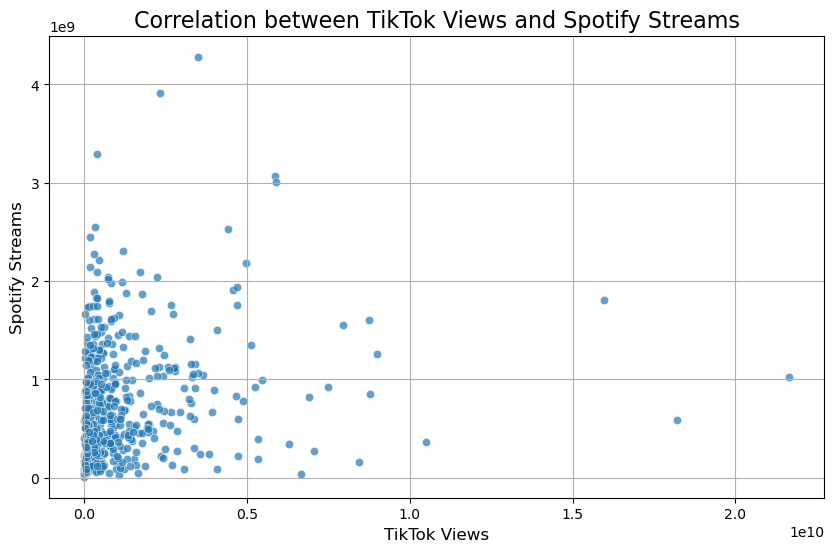

In [109]:

#import matplotlib.pyplot as plt
#clean_df['spotify_streams'] = clean_df['spotify_streams'].str.replace(',', '').astype(float)
#clean_df['tiktok_views'] = clean_df['tiktok_views'].str.replace(',', '').astype(float)

# Check for missing values in relevant columns
#data = data.dropna(subset=['TikTok Views', 'spotify_streams'])

# Correlation Analysis
correlation = clean_df[['tiktok_views', 'spotify_streams']].corr().iloc[0, 1]
print(f"Correlation between TikTok Views and Spotify Streams: {correlation:.2f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clean_df, x='tiktok_views', y='spotify_streams', alpha=0.7)
plt.title('Correlation between TikTok Views and Spotify Streams', fontsize=16)
plt.xlabel('TikTok Views', fontsize=12)
plt.ylabel('Spotify Streams', fontsize=12)
plt.grid(True)
plt.show()

Correlation Matrix:
                       tiktok_views  spotify_streams  deezer_playlist_count  \
tiktok_views               1.000000         0.205695               0.222846   
spotify_streams            0.205695         1.000000               0.656569   
deezer_playlist_count      0.222846         0.656569               1.000000   
pandora_streams           -0.038661         0.538966               0.317511   

                       pandora_streams  
tiktok_views                 -0.038661  
spotify_streams               0.538966  
deezer_playlist_count         0.317511  
pandora_streams               1.000000  


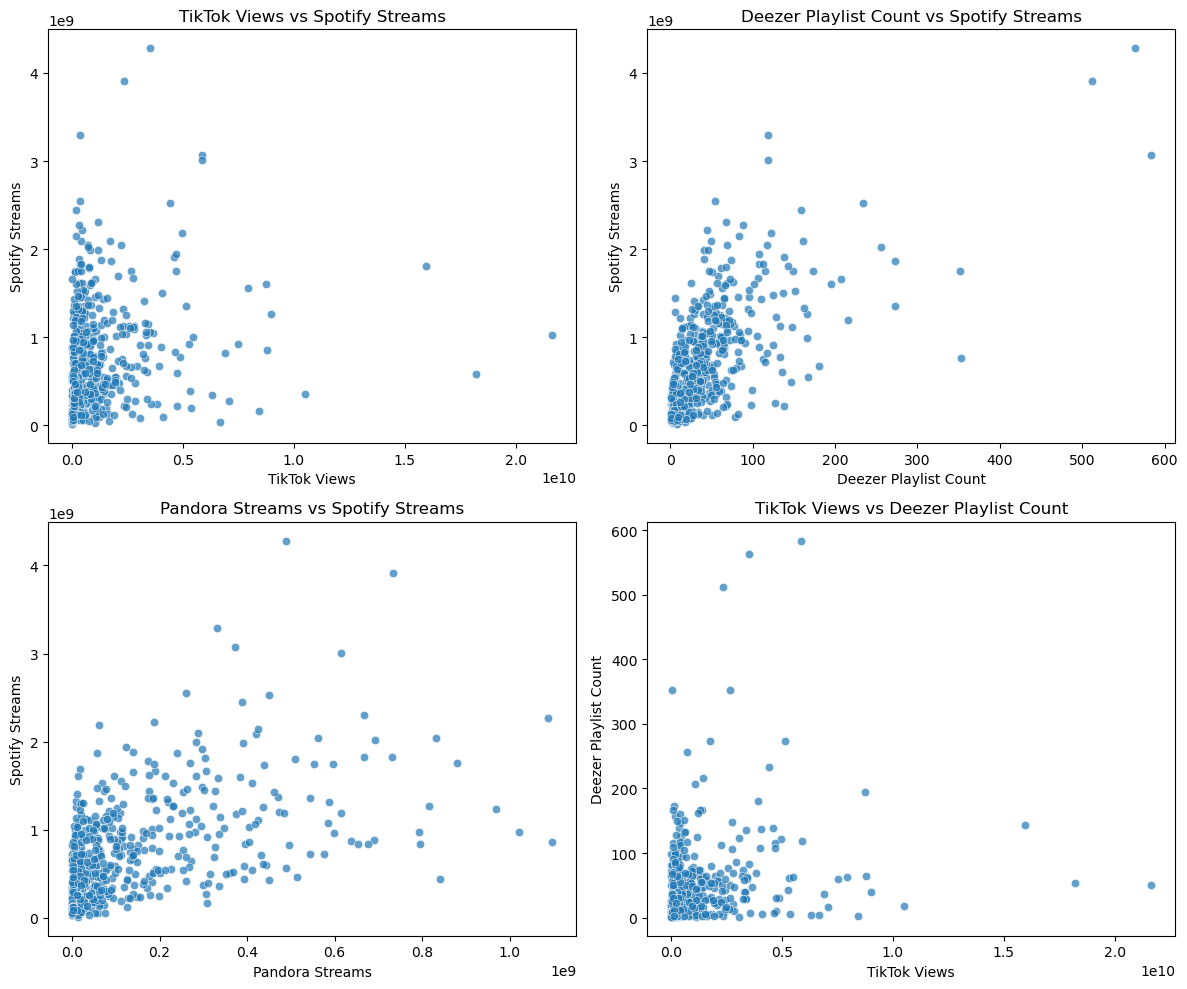

In [110]:
import matplotlib.pyplot as plt
correlation_matrix = clean_df[['tiktok_views', 'spotify_streams','deezer_playlist_count','pandora_streams']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualization: Multiple subplots for pairwise correlations
plt.figure(figsize=(12, 10))

# Scatter plot for TikTok Views vs Spotify Streams
plt.subplot(2, 2, 1)
sns.scatterplot(data=clean_df, x='tiktok_views', y='spotify_streams', alpha=0.7)
plt.title('TikTok Views vs Spotify Streams')
plt.xlabel('TikTok Views')
plt.ylabel('Spotify Streams')

# Scatter plot for Deezer Playlist Count vs Spotify Streams
plt.subplot(2, 2, 2)
sns.scatterplot(data=clean_df, x='deezer_playlist_count', y='spotify_streams', alpha=0.7)
plt.title('Deezer Playlist Count vs Spotify Streams')
plt.xlabel('Deezer Playlist Count')
plt.ylabel('Spotify Streams')

# Scatter plot for Pandora Streams vs Spotify Streams
plt.subplot(2, 2, 3)
sns.scatterplot(data=clean_df, x='pandora_streams', y='spotify_streams', alpha=0.7)
plt.title('Pandora Streams vs Spotify Streams')
plt.xlabel('Pandora Streams')
plt.ylabel('Spotify Streams')

# Scatter plot for TikTok Views vs Deezer Playlist Count
plt.subplot(2, 2, 4)
sns.scatterplot(data=clean_df, x='tiktok_views', y='deezer_playlist_count', alpha=0.7)
plt.title('TikTok Views vs Deezer Playlist Count')
plt.xlabel('TikTok Views')
plt.ylabel('Deezer Playlist Count')

plt.tight_layout()
plt.show()

In [113]:
print(len(clean_df['track'].unique()))

556


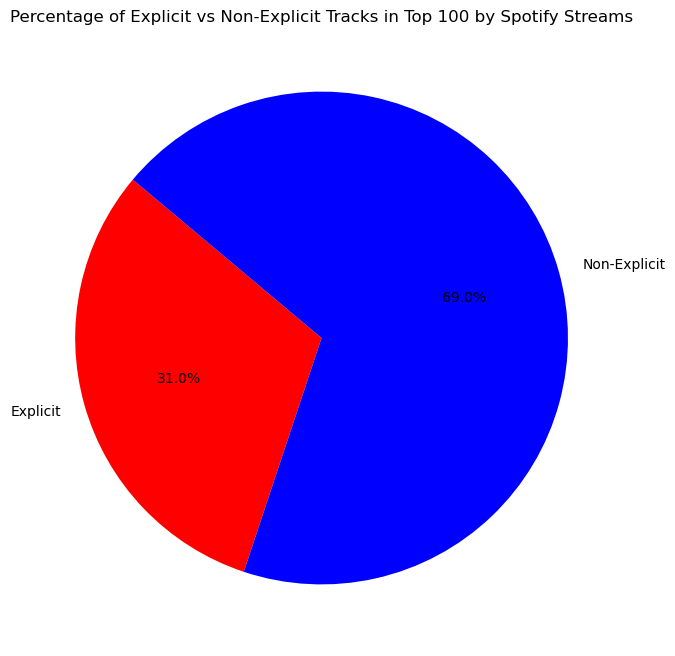

In [114]:
# Pie Chart: Percentage of top 100 tracks with explicit content
# Sort data by Spotify Streams and select the top 100 tracks
data_top_100 = clean_df.nlargest(100, 'spotify_streams')

# Count explicit vs non-explicit tracks
explicit_counts = data_top_100['explicit_track'].value_counts()

# Labels and sizes for the pie chart
labels = ['Explicit', 'Non-Explicit']
sizes = [explicit_counts.get(1, 0), explicit_counts.get(0, 0)]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['red', 'blue'])
plt.title('Percentage of Explicit vs Non-Explicit Tracks in Top 100 by Spotify Streams')
plt.show()

In [124]:
#How does TikTok virality (posts/likes/views) influence other platform metrics like Spotify streams or YouTube views?

Correlation Matrix:
                 tiktok_views  spotify_streams  tiktok_posts  tiktok_likes  \
tiktok_views         1.000000         0.205695      0.661765      0.954219   
spotify_streams      0.205695         1.000000      0.275517      0.220050   
tiktok_posts         0.661765         0.275517      1.000000      0.612747   
tiktok_likes         0.954219         0.220050      0.612747      1.000000   
youtube_views        0.088314         0.645418      0.220296      0.054768   

                 youtube_views  
tiktok_views          0.088314  
spotify_streams       0.645418  
tiktok_posts          0.220296  
tiktok_likes          0.054768  
youtube_views         1.000000  

Summary of Correlations:
tiktok_views shows strong positive correlations with: tiktok_views, tiktok_posts, tiktok_likes
spotify_streams shows strong positive correlations with: spotify_streams, youtube_views
tiktok_posts shows strong positive correlations with: tiktok_views, tiktok_posts, tiktok_likes
tiktok_li

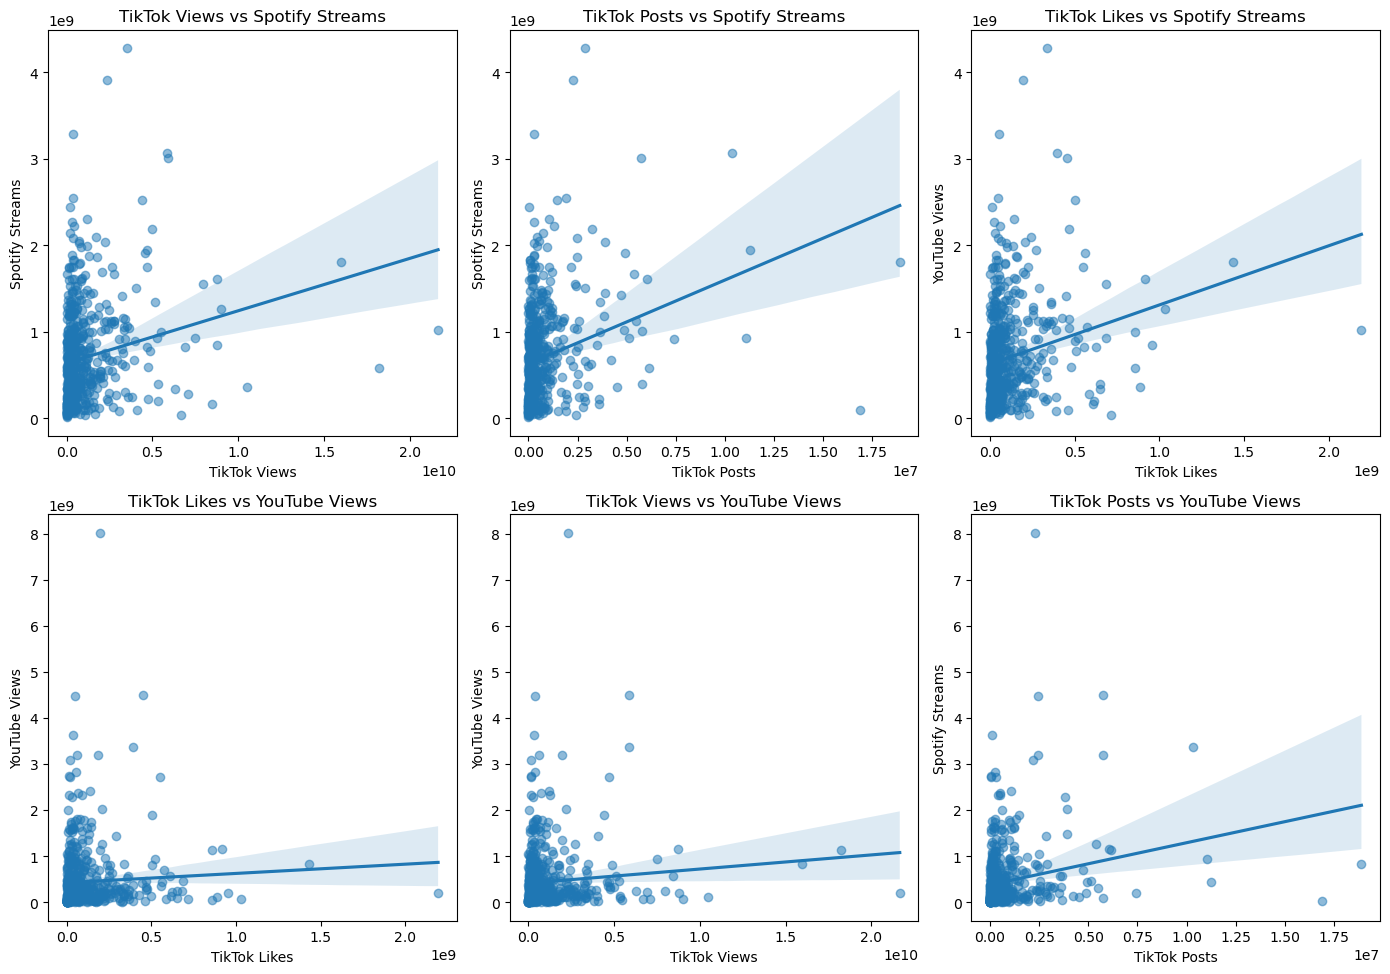

In [125]:


# Create a correlation matrix
correlation_tiktok_matrix = clean_df[['tiktok_views','spotify_streams','tiktok_posts','tiktok_likes','youtube_views']].corr()
print("Correlation Matrix:")
print(correlation_tiktok_matrix)

# Brief summary of correlation findings
print("\nSummary of Correlations:")
for col in correlation_tiktok_matrix.columns:
    significant_correlations = correlation_tiktok_matrix[col][correlation_tiktok_matrix[col] > 0.5]
    print(f"{col} shows strong positive correlations with: {', '.join(significant_correlations.index)}")

# Visualization: How TikTok virality influences other platform metrics
plt.figure(figsize=(14, 10))

# Scatter plot for TikTok Views vs Spotify Streams
plt.subplot(2, 3, 1)
sns.regplot(data=clean_df, x='tiktok_views', y='spotify_streams', scatter_kws={"alpha": 0.5})
plt.title('TikTok Views vs Spotify Streams')
plt.xlabel('TikTok Views')
plt.ylabel('Spotify Streams')

# Scatter plot for TikTok Posts vs Spotify Streams
plt.subplot(2, 3, 2)
sns.regplot(data=clean_df, x='tiktok_posts', y='spotify_streams', scatter_kws={"alpha": 0.5})
plt.title('TikTok Posts vs Spotify Streams')
plt.xlabel('TikTok Posts')
plt.ylabel('Spotify Streams')

# Scatter plot for TikTok Likes vs YouTube Views
plt.subplot(2, 3, 3)
sns.regplot(data=clean_df, x='tiktok_likes', y='spotify_streams', scatter_kws={"alpha": 0.5})
plt.title('TikTok Likes vs Spotify Streams')
plt.xlabel('TikTok Likes')
plt.ylabel('YouTube Views')

# Scatter plot for TikTok Likes vs YouTube Views
plt.subplot(2, 3, 4)
sns.regplot(data=clean_df, x='tiktok_likes', y='youtube_views', scatter_kws={"alpha": 0.5})
plt.title('TikTok Likes vs YouTube Views')
plt.xlabel('TikTok Likes')
plt.ylabel('YouTube Views')

# Scatter plot for TikTok Views vs YouTube Views
plt.subplot(2, 3, 5)
sns.regplot(data=clean_df, x='tiktok_views', y='youtube_views', scatter_kws={"alpha": 0.5})
plt.title('TikTok Views vs YouTube Views')
plt.xlabel('TikTok Views')
plt.ylabel('YouTube Views')

# Scatter plot for TikTok Posts vs Spotify Streams
plt.subplot(2, 3, 6)
sns.regplot(data=clean_df, x='tiktok_posts', y='youtube_views', scatter_kws={"alpha": 0.5})
plt.title('TikTok Posts vs YouTube Views')
plt.xlabel('TikTok Posts')
plt.ylabel('Spotify Streams')

plt.tight_layout()
plt.show()

In [120]:
clean_df.groupby('track')['spotify_streams'].max()

track
0800 HEAVEN                                6.818986e+07
2055                                       8.117002e+08
500lbs                                     3.505842e+08
7 Summers                                  4.334297e+08
8:00 AM                                    1.354653e+08
                                               ...     
this is what falling in love feels like    4.776208e+08
vampire                                    9.989641e+08
wait in the truck (feat. Lainey Wilson)    1.272234e+08
we fell in love in october                 1.034273e+09
you broke me first                         1.439466e+09
Name: spotify_streams, Length: 556, dtype: float64

In [42]:
#clean_df.groupby('album_name')['spotify_streams'].max().sort_values(ascending=True).head(20).sort_values()
   # .sort_values(ascending=False) \
    #.head(10) \
    #.sort_values() \
#clean_df = clean_df.replace(r'^\s*$', np.nan, regex=True)
#clean_df['spotify_streams'] = clean_df['spotify_popularity'].astype(float)

top_tracks = clean_df.nlargest(15, "spotify_popularity")

# Group by album name and sum the Spotify streams for each album
top_tracks_grouped = top_tracks.groupby("album_name", as_index=False).sum()

# Sort by Spotify streams for better visualization
top_tracks_grouped = top_tracks_grouped.sort_values("spotify_popularity", ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=top_tracks_grouped, x="spotify_popularity", y="album_name", palette="viridis")

# Add labels and title
plt.xlabel("Total Spotify Streams", fontsize=12)
plt.ylabel("Album Name", fontsize=12)
plt.title("Top 15 Tracks: Total Spotify Streams by Album", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


TypeError: datetime64 type does not support sum operations

In [14]:
# Data preprocessing
# Convert "Spotify Streams" to numeric by removing commas
new_df['spotify_streams'] = new_df['spotify_streams'].str.replace(',', '').astype(float)

# Ensure "Explicit Track" is numeric (if not already)
new_df['explicit_track'] = new_df['explicit_track'].astype(int)

# Calculate correlation between "Explicit Track" and "Spotify Streams"
correlation = new_df[['explicit_track', 'spotify_streams']].corr().iloc[0, 1]

# Display correlation result
correlation

-0.08004005850191913

General Distribution and Summaries


Track Score

What is the average track score across all tracks?
What is the distribution of track scores?


Spotify Streams

What is the total number of Spotify streams for all tracks?
Which track has the highest number of Spotify streams?


Spotify Popularity

What is the distribution of Spotify popularity scores?
Is there a correlation between Spotify popularity and Spotify streams?


Release Date

What is the average release year for tracks?
How has the number of track releases changed over time?


Explicit Track

What percentage of tracks are marked as explicit?
Are explicit tracks more likely to have higher Spotify popularity scores?
